In [2]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reload a trained model

In [61]:
### Load data
train = pd.read_hdf("train_dnn.h5")
val = pd.read_hdf("val_dnn.h5")
test = pd.read_hdf("test_dnn.h5")
test.reset_index(inplace=True)

### All clusters + track eta/phi/z0
train_vars = [var for var in test.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
val_x = val[train_vars].values
val_y = val['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
val_x = sc.transform(val_x)
test_x = sc.transform(test_x)

def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

model = regression_model()
model.load_weights("dnn_best_weights_50.h5")
test['nn_output'] = 10**model.predict(test_x) # re-exponentiate the energy

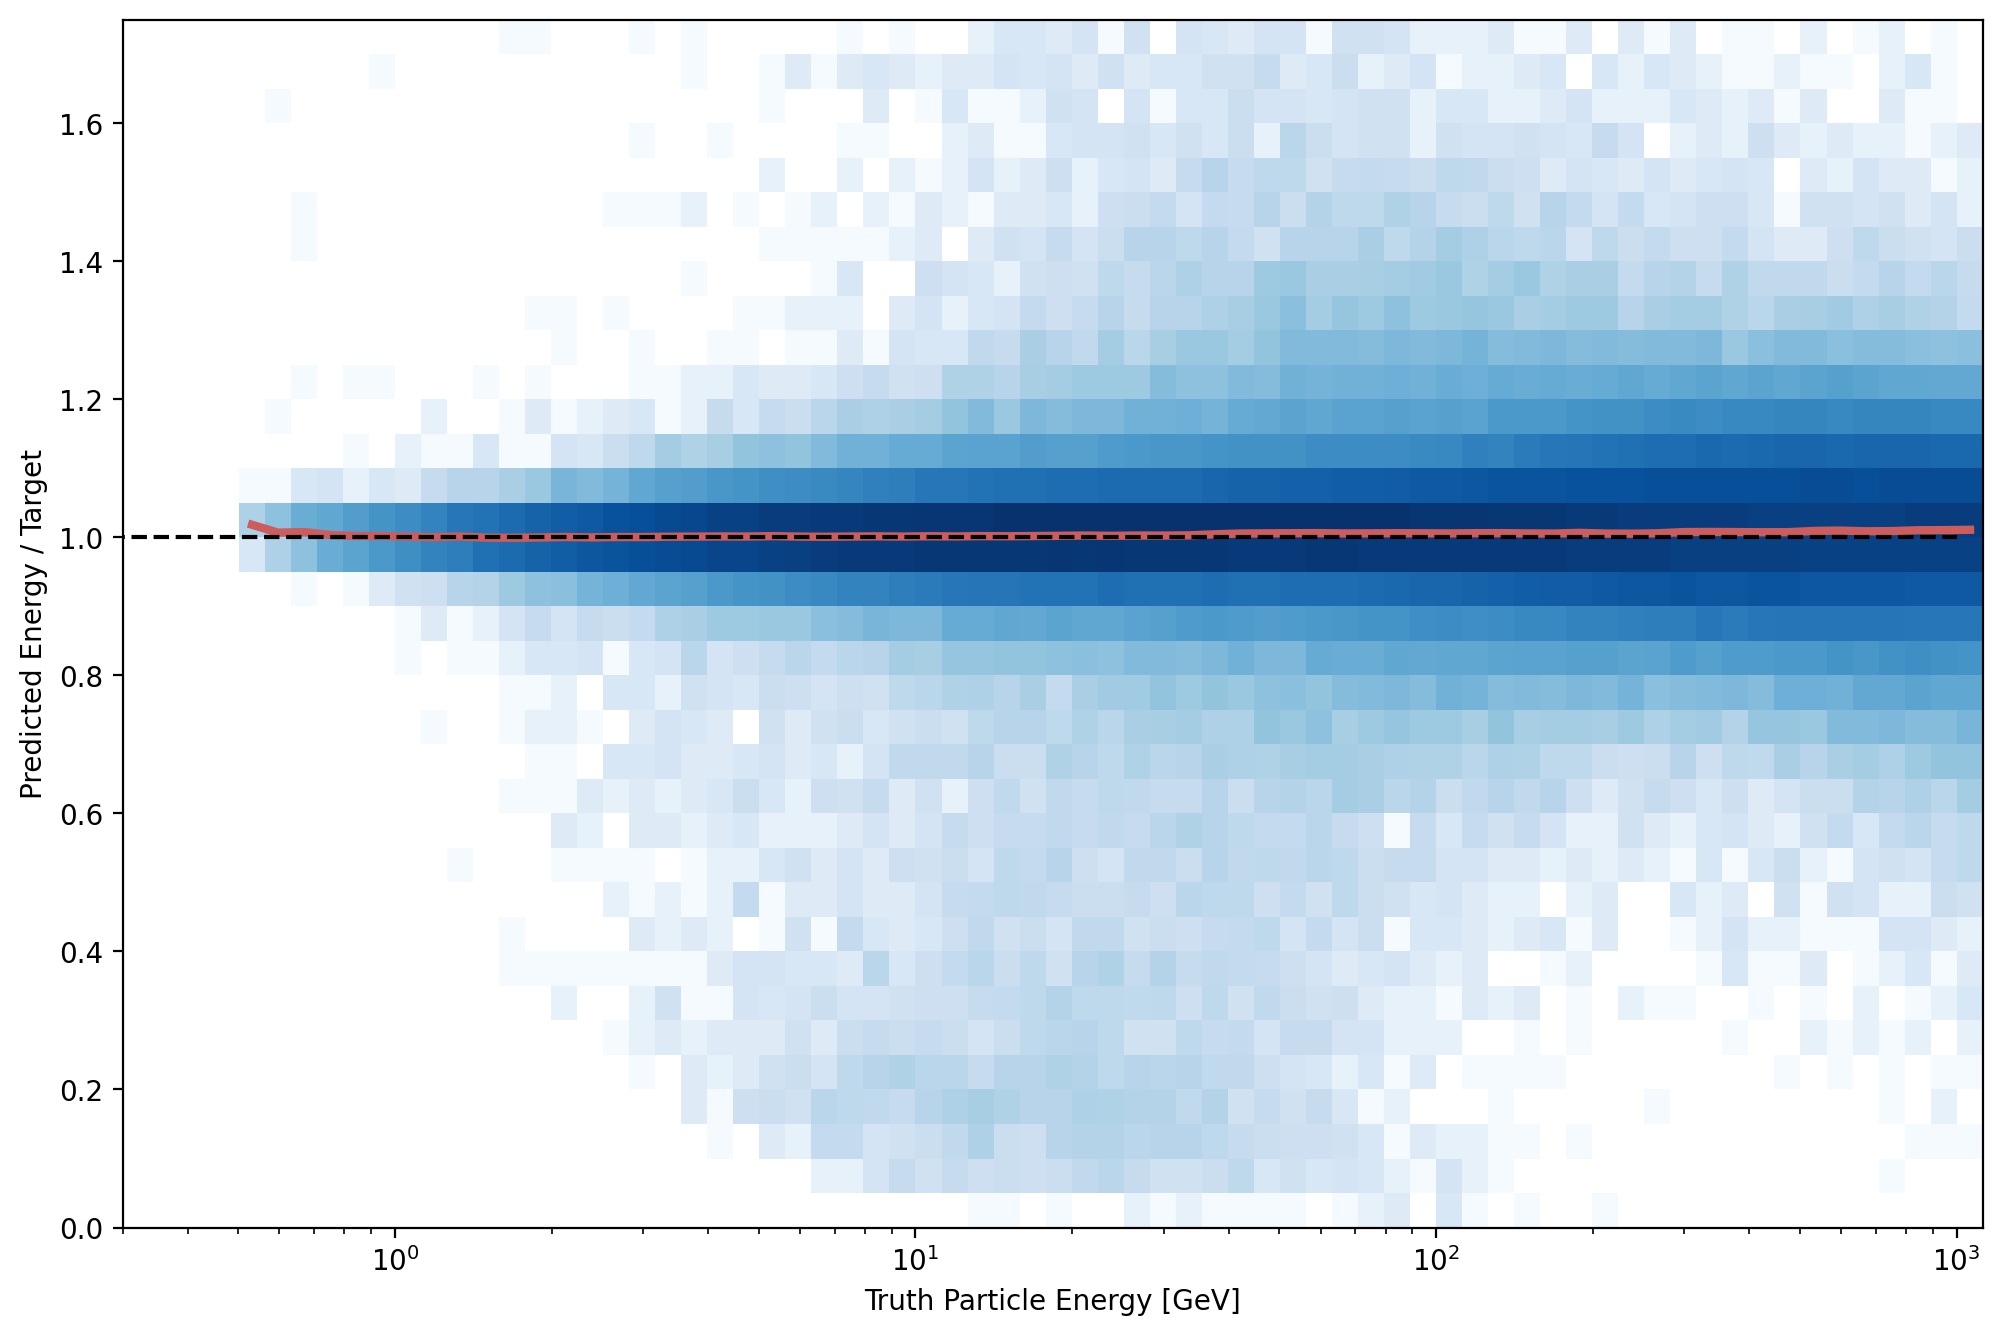

In [62]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e
y = (test.nn_output)/x

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
# np.savez('pub_note_results/response_medians_dnn_2.npz', response_median=profileXMed, xcenter=xcenter)

In [63]:
np.min(test.nn_output/test.truth_particle_e)

0.0222355404175313

In [64]:
test[(test.truth_particle_e > 100) & (test.truth_particle_e < 101) & 
   (test.nn_output/test.truth_particle_e < 0.2)][["nn_output", "truth_particle_e"]]

,nn_output,truth_particle_e
966165,5.142074,100.291687


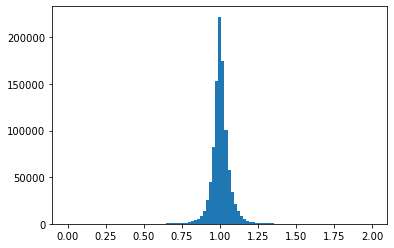

In [65]:
plt.hist(test.nn_output/test.truth_particle_e, bins=np.linspace(0,2,100));

Now compare to Transformer event...

In [66]:
transformer = np.load('pub_note_results/Attention_Prediction_TRK_MarielFile.npz') # as of July 24
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

In [67]:
len(test) == len(df_transformer)

True

In [69]:
test.truth_particle_e

0             5.482727
1            26.158798
2            14.467227
3             4.749291
4             4.548028
              ...     
1001265    1213.735718
1001266      44.486908
1001267      20.240547
1001268      85.486588
1001269     108.328667
Name: truth_particle_e, Length: 1001270, dtype: float64

In [70]:
df_transformer.targets_regress

0             5.482727
1            26.158798
2            14.467227
3             4.749291
4             4.548028
              ...     
1001265    1213.735718
1001266      44.486908
1001267      20.240547
1001268      85.486588
1001269     108.328667
Name: targets_regress, Length: 1001270, dtype: float64

In [72]:
np.sum(test.truth_particle_e == df_transformer.targets_regress)/len(test) 
# okay, so these are definitely identical events!

1.0

In [73]:
np.min(df_transformer.outputs_regress/df_transformer.targets_regress)

0.8191938248649204

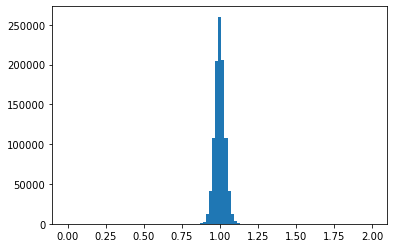

In [74]:
plt.hist(df_transformer.outputs_regress/df_transformer.targets_regress, bins=np.linspace(0,2,100));

In [96]:
test[(np.abs(test.truth_particle_e - 1000) < 5)  # close to 100 GeV
     & 
     (test.nn_output/test.truth_particle_e < 0.5)  # DNN does badly
    ][["nn_output", "truth_particle_e"]]

,nn_output,truth_particle_e
6509,479.300934,998.924377
480384,350.038086,1001.998108
877017,433.330139,995.507751
970158,178.208893,995.071655


In [97]:
test.iloc[970158].nn_output

178.20889282226562

In [98]:
df_transformer.iloc[970158]

targets_regress    995.071655
outputs_regress    968.038875
Name: 970158, dtype: float64

In [99]:
indices = [73920, 379097, 585445, 966165, 278235, 970158]

In [103]:
test.keys()

Index(['index', 'cluster_e_0', 'cluster_e_1', 'cluster_e_2', 'cluster_e_3',
       'cluster_e_4', 'cluster_e_5', 'cluster_e_6', 'cluster_e_7',
       'cluster_e_8', 'cluster_e_9', 'cluster_e_10', 'cluster_e_11',
       'cluster_e_12', 'cluster_e_13', 'cluster_e_14', 'cluster_e_15',
       'cluster_e_16', 'cluster_e_17', 'cluster_e_18', 'cluster_e_19',
       'cluster_e_20', 'cluster_e_21', 'cluster_e_22', 'cluster_e_23',
       'cluster_e_24', 'cluster_e_25', 'cluster_e_26', 'cluster_e_27',
       'cluster_e_28', 'cluster_e_29', 'cluster_e_30', 'cluster_e_31',
       'cluster_e_32', 'track_pt', 'track_eta', 'track_phi', 'track_z0',
       'truth_particle_e', 'log10_cluster_e_0', 'log10_cluster_e_1',
       'log10_cluster_e_2', 'log10_cluster_e_3', 'log10_cluster_e_4',
       'log10_cluster_e_5', 'log10_cluster_e_6', 'log10_cluster_e_7',
       'log10_cluster_e_8', 'log10_cluster_e_9', 'log10_cluster_e_10',
       'log10_cluster_e_11', 'log10_cluster_e_12', 'log10_cluster_e_13',
       

In [110]:
test.iloc[indices].truth_particle_e

73920       1.638227
379097      9.119415
585445     29.691723
966165    100.291687
278235    499.597717
970158    995.071655
Name: truth_particle_e, dtype: float64

# Load data

### Premade

In [ ]:
df_train = pd.read_hdf("train_dnn.h5")
df_val = pd.read_hdf("val_dnn.h5")
df_test = pd.read_hdf("test_dnn.h5")

### or, remake from scratch:

In [ ]:
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
train = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:350])])
val = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[350:400])])
test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[400:])])
test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:2])])
print("Training dataframe has {:,} events.".format(train.shape[0]))
print("Validation dataframe has {:,} events.".format(val.shape[0]))
print("Testing dataframe has {:,} events.".format(test.shape[0]))

In [ ]:
def process(df): 
    ### Start the dataframe of inputs 
    ncols = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(ncols)]))

    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)

    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Do this again? 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    return df2

In [ ]:
df_train = process(train)
df_val = process(val)
df_test = process(test)

In [ ]:
df_train.to_hdf("train_dnn.h5", "df")
df_val.to_hdf("val_dnn.h5", "df")
df_test.to_hdf("test_dnn.h5", "df")

# Preprocess

In [ ]:
### All clusters + track pt/eta/phi/z0
train_vars = [var for var in df_train.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
train_vars += ['track_eta', 'track_phi', 'track_z0']

### Augment df_test with any extra columns
df_test[[var for var in df_train.keys() if var not in df_test.keys()]] = 0 

train_x = df_train[train_vars].values
train_y = df_train['log10_truth_particle_e'].values
val_x = df_val[train_vars].values
val_y = df_val['log10_truth_particle_e'].values
test_x = df_test[train_vars].values
test_y = df_test['log10_truth_particle_e'].values

In [ ]:
# train_vars.remove('log10_cluster_e_33')
# train_vars.remove('log10_cluster_e_34')

In [ ]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
val_x = sc.transform(val_x)
test_x = sc.transform(test_x)

In [ ]:
train_x.shape[1]

In [ ]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, 
                    input_dim=train_x.shape[1], 
                    activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [ ]:
model = regression_model()
model.summary()

# Load pre-trained weights

In [ ]:
# model.load_weights("dnn_best_weights_50.h5")

# Or, re-train

In [ ]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
#     validation_split=0.2,
    batch_size=32,
    verbose=1, epochs=10)

# Load test set

In [ ]:
pred_file = 'results/onetrack_multicluster/piyush_june22/gnn_allclusters_cells/inference_predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets']
outputs_regress = predictions['outputs'][:,0]
df = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])

In [ ]:
plt.figure(dpi=200)
plt.hist(df_transformer.outputs_regress/df_transformer.targets_regress, 
        bins=np.linspace(0.5,1.5,100),
         label="Transformer",
        );
plt.legend()
plt.xlabel("Predicted Energy / Target Energy");
plt.ylabel("Events");

In [ ]:
plt.figure(dpi=200)
plt.hist(df_test.truth_particle_e, label="DNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df.targets_regress, label="GNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df_transformer.targets_regress, label="Transformer", histtype="step", alpha=1., density=True, linewidth=2);
plt.legend();
plt.xlabel("Target Energy [GeV]");

In [ ]:
### Evaluate performance on test set 
df_test['nn_output'] = model.predict(test_x)
plt.hist(df_test.nn_output/df_test.log10_truth_particle_e, bins=np.linspace(0.9,1.1,40));

In [ ]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = df_test.truth_particle_e
y = (10**df_test.nn_output)/x

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
# np.savez('pub_note_results/response_medians_dnn_2.npz', response_median=profileXMed, xcenter=xcenter)

In [ ]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
resolution = stats.binned_statistic(x, y, bins=xbin, statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

# np.savez('pub_note_results/iqr_dnn_2.npz', iqr=resolution, xcenter=xcenter)

# Misc

In [ ]:
train = pd.read_hdf("train_dnn.h5")
val = pd.read_hdf("val_dnn.h5")
test = pd.read_hdf("test_dnn.h5")

In [ ]:
import uproot
from glob import glob
import json 
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE"]

df_all = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df_all["truthPartE"] = df_all.truthPartE.astype('float')
df_all.reset_index(inplace=True)

In [ ]:
pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE", "cluster_E"]

df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df["truthPartE"] = df.truthPartE.astype('float')
df.reset_index(inplace=True)

print(df[(df.truthPartE < 0.201)].nTrack.value_counts())
print("Minimum truthPartE with nTrack == 1 is {:.5f}.".format(df[df.nTrack == 1].truthPartE.min()))


In [ ]:
cluster_e = []
for i in tqdm(range(len(df))): 
    event_pass = True
    for cluster in range(len(df.cluster_E.iloc[i])):
        if np.array(df.cluster_E.iloc[i][cluster]) > 0.5: 
            event_pass = False
            continue
    cluster_e.append(event_pass)